In [46]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras



In [47]:
# print tensorflow version
print(tf.__version__)


2.10.0


# LOAD DATA

In [60]:
df = pd.read_csv('datasetiot.csv')
# keep 100 000 first rows
df = df.iloc[:100000]
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
#set category types
df['label'].cat.set_categories(['Normal', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)

# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'Normal'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'Normal'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:26429, 'label'] = 'Normal'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'Normal'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'Normal'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'
# merge label SSH and FTP + SSH and FTP as "Normal"




C:\Users\enzoh\AppData\Local\Temp\ipykernel_16920\2672390871.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


In [59]:
# print how many different labels we have
print(df['label'].value_counts())

Normal           35880
SYN Flood        22849
Keylogger        12101
Reverse Shell     7600
Name: label, dtype: int64


# Visulation of the data

In [49]:
# print column names
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


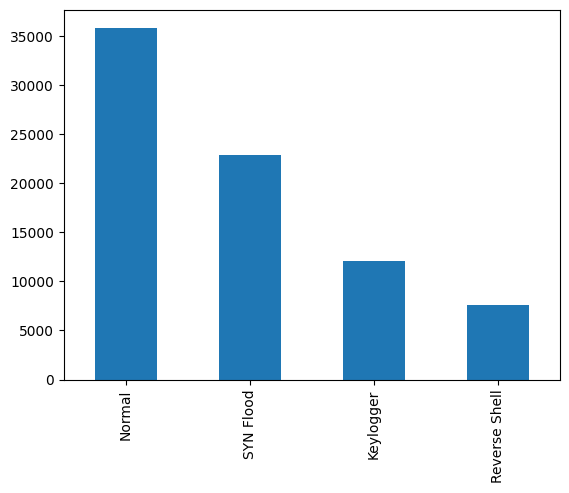

In [61]:
# show and plot  the number of samples for each label
df['label'].value_counts().plot(kind='bar')
plt.show()
# show the number of samples for each label
df['label'].value_counts()
# labels is all the labels
labels = df['label'].values


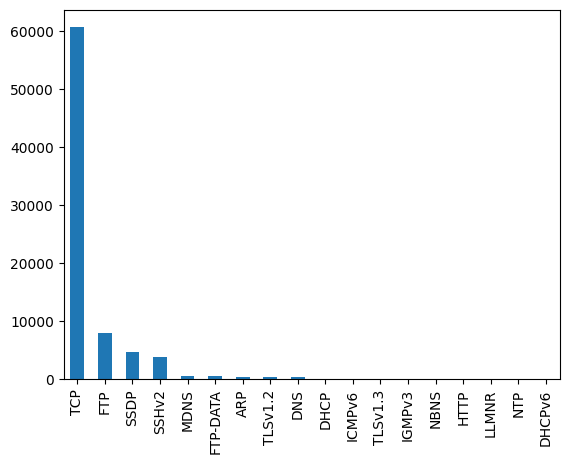

TCP         60676
FTP          8029
SSDP         4664
SSHv2        3798
MDNS          543
FTP-DATA      511
ARP           385
TLSv1.2       354
DNS           352
DHCP          134
ICMPv6        123
TLSv1.3       120
IGMPv3        112
NBNS           72
HTTP           49
LLMNR          48
NTP            24
DHCPv6          6
Name: Protocol, dtype: int64

In [62]:
# show count for each protocol
df['Protocol'].value_counts().plot(kind='bar')
plt.show()
# show count for each protocol
df['Protocol'].value_counts()


# LSTM model

In [63]:
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_data(df, window_size=128):
    """Prepare the data for the LSTM model. Normalize the data, and transform objects to numerical values.

    Args:
        df: pandas dataframe
        window_size: the number of samples to put in a sequence

    Returns:
        Tuple: X, y
            - X (np.array): Features.
            - y (np.array): Labels.
    """

    # Extract relevant features
    X = df.drop('label', axis=1)  # Drop the label column
    y = df['label']

    # Label encoding for categorical columns
    label_encoder = LabelEncoder()
    X_encoded = X.apply(label_encoder.fit_transform)  # Apply label encoding to all columns

    # encode the labels
    y_encoded = label_encoder.fit_transform(y)


    # Create sliding window sequences of data
    num_samples = len(X_encoded)
    num_features = X_encoded.shape[1]
    X_sequences = np.zeros((num_samples - window_size + 1, window_size, num_features))
    y_labels = np.zeros((num_samples - window_size + 1,), dtype=int)
    for i in range(num_samples - window_size + 1):
        X_sequences[i] = X_encoded[i:i + window_size]
        y_labels[i] = y_encoded[i + window_size - 1]
    return X_sequences, y_labels, label_encoder

    





In [66]:
# tf version
print(tf.__version__)


2.10.0


In [67]:
# Define the indices for training, validation, and test sets
train_indices = [(0, 3500), (5150, 13000), (18600, 24500), (28000, 35000), (40100, 44000), (46500, 51500), (54101, int((len(df))*0.7))]
val_indices = [(3501, 4300), (13001, 15500), (24501, 26500), (35001, 37500), (44000, 45250), (51501, 52750), (int((len(df))*0.7), int((len(df))*0.85))]
test_indices = [(4301, 5150), (15501, 18600), (26501, 28000), (37501, 40100), (45251, 46500), (52750, 54100), (int((len(df))*0.85), len(df))]

# create the training, validation, and test dataframes, including the parts inside each tuple
train_df = pd.concat([df.iloc[start:end] for start, end in train_indices])
val_df = pd.concat([df.iloc[start:end] for start, end in val_indices])
test_df = pd.concat([df.iloc[start:end] for start, end in test_indices])

# print shapes
print(df.shape,train_df.shape, val_df.shape, test_df.shape)

# reset the indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


#print all dtypes
print(train_df.dtypes)
print(val_df.dtypes)
print(test_df.dtypes)
window_size = 128
train_df_data, train_target,label_encoder_train = prepare_data(train_df, window_size)
val_df_data, val_target,label_encoder_val = prepare_data(val_df, window_size)
test_df_data, test_target, label_encoder_test= prepare_data(test_df, window_size)
# print("aaaaaaaaaaaaa",train_df_data.shape, train_target.shape)
# val_df_data, val_target = prepare_data(val_df)
# test_df_data, test_target = prepare_data(test_df)
# num_features = train_df_data.shape[2]

num_features = train_df_data.shape[2]
print(num_features)

(80000, 8) (35049, 8) (22295, 8) (22645, 8)
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
7


In [69]:
# train lstm smodel_stacked_LSTM
num_features = train_df_data.shape[2]
input_shape = (window_size, num_features)

smodel_stacked_LSTM = keras.Sequential()
smodel_stacked_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(64, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(64))
smodel_stacked_LSTM.add(keras.layers.Dense(32, activation='relu'))
smodel_stacked_LSTM.add(keras.layers.Dense(7, activation='softmax'))
smodel_stacked_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
smodel_stacked_LSTM.summary()

model_single_LSTM = keras.Sequential()
model_single_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
model_single_LSTM.add(keras.layers.LSTM(64))
model_single_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_single_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single_LSTM.summary()

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN.add(keras.layers.Flatten())
model_CNN.add(keras.layers.Dense(50, activation='relu'))
model_CNN.add(keras.layers.Dense(7, activation='softmax'))
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN.summary()

model_CNN2 = keras.Sequential()
model_CNN2.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN2.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_CNN2.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN2.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_CNN2.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN2.add(keras.layers.Flatten())
model_CNN2.add(keras.layers.Dense(50, activation='relu'))
model_CNN2.add(keras.layers.Dense(7, activation='softmax'))
model_CNN2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN2.summary()



model_CNN_LSTM = keras.Sequential()
model_CNN_LSTM.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
model_CNN_LSTM.add(keras.layers.LSTM(64))
model_CNN_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_CNN_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN_LSTM.summary()

model_bidirectional_LSTM = keras.Sequential()
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), input_shape=input_shape))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_bidirectional_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_bidirectional_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidirectional_LSTM.summary()

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_RNN.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_RNN.add(keras.layers.SimpleRNN(64))
model_RNN.add(keras.layers.Dense(32, activation='relu'))
model_RNN.add(keras.layers.Dense(7, activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()

model_rnn_lstm = keras.Sequential()
model_rnn_lstm.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_rnn_lstm.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_rnn_lstm.add(keras.layers.SimpleRNN(64, return_sequences=True))
model_rnn_lstm.add(keras.layers.LSTM(64))
model_rnn_lstm.add(keras.layers.Dense(32, activation='relu'))
model_rnn_lstm.add(keras.layers.Dense(7, activation='softmax'))
model_rnn_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn_lstm.summary()

model_chelou = keras.Sequential()
model_chelou.add(keras.layers.LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
model_chelou.add(keras.layers.LSTM(32, activation='relu', return_sequences=True))
model_chelou.add(keras.layers.Flatten())
model_chelou.add(keras.layers.RepeatVector(window_size))
model_chelou.add(keras.layers.LSTM(32, activation='relu', return_sequences=True))
model_chelou.add(keras.layers.LSTM(64, activation='relu', return_sequences=True))
model_chelou.add(keras.layers.TimeDistributed(keras.layers.Dense(7)))
model_chelou.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_chelou.summary()

model_list = [model_single_LSTM, model_CNN, model_CNN2, model_CNN_LSTM, model_bidirectional_LSTM, model_RNN, model_rnn_lstm, model_chelou]



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 128, 128)          69632     
                                                                 
 lstm_31 (LSTM)              (None, 128, 128)          131584    
                                                                 
 lstm_32 (LSTM)              (None, 128, 64)           49408     
                                                                 
 lstm_33 (LSTM)              (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 7)                 231       
                                                                 
Total params: 285,959
Trainable params: 285,959
Non-tr

In [10]:
# show how len many unique labels there are
print(len(np.unique(train_target)))

3


In [11]:
smodel_stacked_LSTM.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          69632     
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 lstm_2 (LSTM)               (None, 128, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 285,959
Trainable params: 285,959
Non-trai

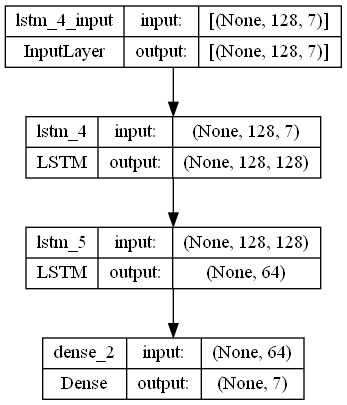

In [12]:
#draw model
from keras.utils.vis_utils import plot_model
plot_model(smodel_stacked_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# plot single model
plot_model(model_single_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



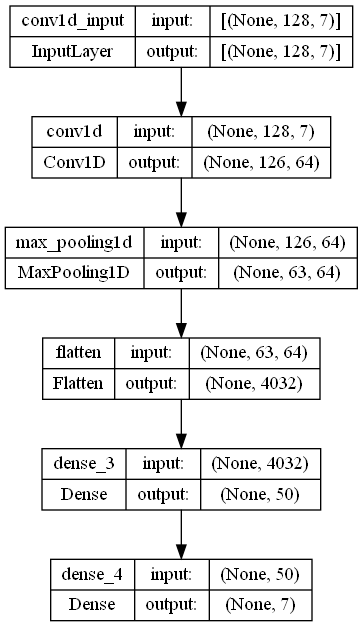

In [13]:
plot_model(model_CNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

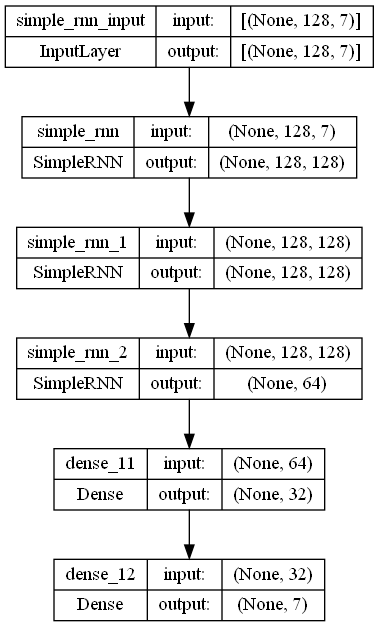

In [14]:
plot_model(model_RNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

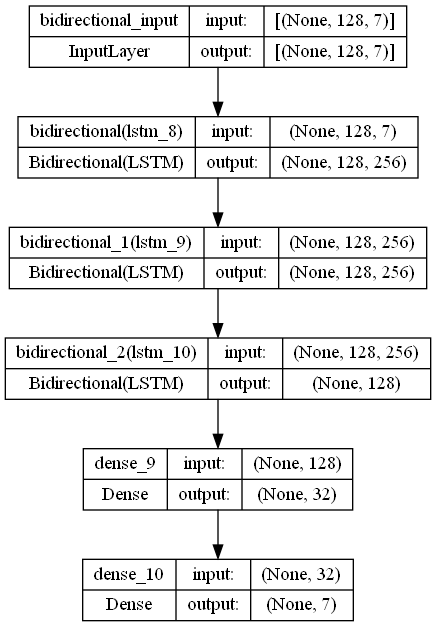

In [15]:
plot_model(model_bidirectional_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

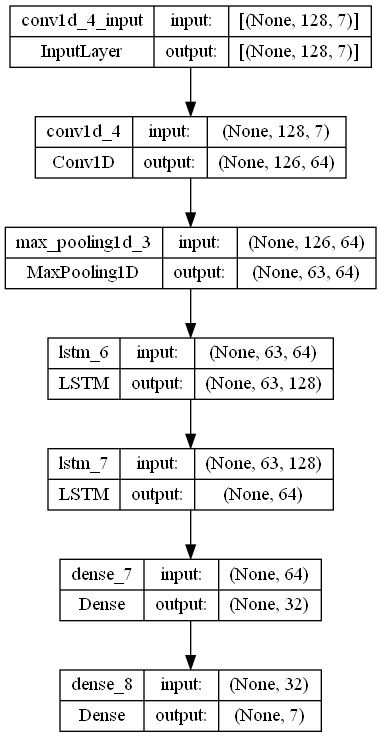

In [16]:
plot_model(model_CNN_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

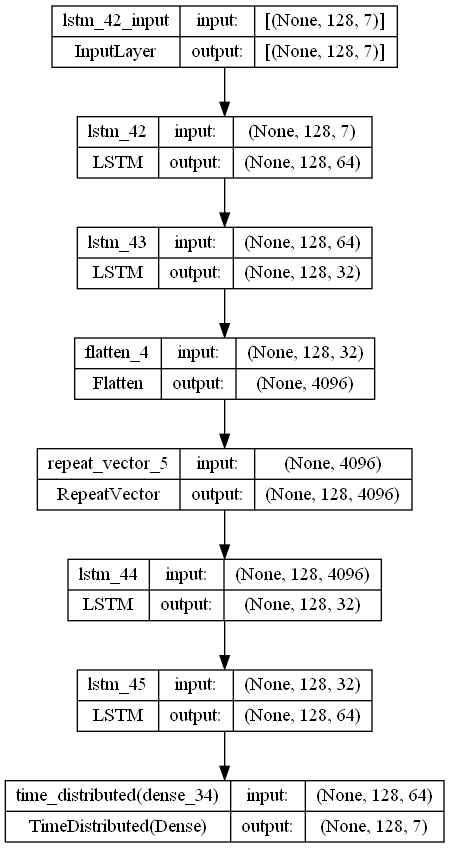

In [70]:
plot_model(model_chelou, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
#show GPU info
!nvidia-smi


Wed Apr  5 22:13:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0    29W / 125W |   5976MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# clear memory of tensorflow
import tensorflow as tf
tf.keras.backend.clear_session()


In [72]:

history_single_LSTM = model_single_LSTM.fit(train_df_data, train_target, epochs=25, batch_size=64, validation_data=(val_df_data, val_target))
# history_CNN = model_CNN.fit(train_df_data, train_target, epochs=100, batch_size=128, validation_data=(val_df_data, val_target))
# history_CNN2 = model_CNN2.fit(train_df_data, train_target, epochs=100, batch_size=128, validation_data=(val_df_data, val_target))
# history_CNN_LSTM = model_CNN_LSTM.fit(train_df_data, train_target, epochs=25, batch_size=128, validation_data=(val_df_data, val_target))
# history_bidirectional_LSTM = model_bidirectional_LSTM.fit(train_df_data, train_target, epochs=25, batch_size=128, validation_data=(val_df_data, val_target))
# history_RNN = model_RNN.fit(train_df_data, train_target, epochs=25, batch_size=128, validation_data=(val_df_data, val_target))
# history_stacked_LSTM = smodel_stacked_LSTM.fit(train_df_data, train_target, epochs=25, batch_size=256, validation_data=(val_df_data, val_target))
# history_rnn_lstm = model_rnn_lstm.fit(train_df_data, train_target, epochs=25, batch_size=128, validation_data=(val_df_data, val_target))

Epoch 1/25
546/546 [==============================] - 14s 24ms/step - loss: 0.2847 - accuracy: 0.9037 - val_loss: 4.4203 - val_accuracy: 0.3778
Epoch 2/25
546/546 [==============================] - 12s 22ms/step - loss: 0.3715 - accuracy: 0.8529 - val_loss: 3.7808 - val_accuracy: 0.4197
Epoch 3/25
546/546 [==============================] - 12s 23ms/step - loss: 0.2670 - accuracy: 0.8952 - val_loss: 5.4700 - val_accuracy: 0.4135
Epoch 4/25
546/546 [==============================] - 12s 23ms/step - loss: 0.1296 - accuracy: 0.9550 - val_loss: 5.6050 - val_accuracy: 0.4305
Epoch 5/25
546/546 [==============================] - 12s 23ms/step - loss: 0.1003 - accuracy: 0.9666 - val_loss: 5.6145 - val_accuracy: 0.4136
Epoch 6/25
546/546 [==============================] - 13s 23ms/step - loss: 0.1141 - accuracy: 0.9621 - val_loss: 5.5892 - val_accuracy: 0.4220
Epoch 7/25
546/546 [==============================] - 13s 24ms/step - loss: 0.0947 - accuracy: 0.9713 - val_loss: 5.5882 - val_accuracy:

In [82]:
# predict and show report and confusion matrix with the original labels that were string
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predict with the model
y_pred = model_single_LSTM.predict(val_df_data)
y_pred_labels = np.argmax(y_pred, axis=1)
reverse_label_map = {label_encoder_test.transform([label])[0]: label for label in label_encoder_test.classes_}
y_pred_labels = np.vectorize(reverse_label_map.get)(y_pred_labels)
y_true_labels = np.vectorize(reverse_label_map.get)(val_target)

# print classification report
print(classification_report(y_true_labels, y_pred_labels))

# print confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder_test.classes_)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder_test.classes_, yticklabels=label_encoder_test.classes_)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()







693/693 [==============================] - 6s 8ms/step
               precision    recall  f1-score   support

    Keylogger       0.26      0.98      0.41      2499
       Normal       0.58      0.95      0.72      7501
Reverse Shell       0.00      0.00      0.00      1249
    SYN Flood       0.00      0.00      0.00     10849
          nan       0.00      0.00      0.00        70

     accuracy                           0.43     22168
    macro avg       0.17      0.39      0.23     22168
 weighted avg       0.23      0.43      0.29     22168



c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

TypeError: '<' not supported between instances of 'float' and 'str'

In [24]:
def plot_model_loss_accuracy(history,model_name):
  """ Plot the model loss and accuracy for training and validation data

  Args:
      history (keras.callbacks.History): History object returned by model.fit()
      model_name (str): Name of the model
  """
  plt.plot(history.history['accuracy'],label="Training Accuracy")
  plt.plot(history.history['val_accuracy'],label="Validation Accuracy")

  plt.plot(history.history['loss'],label="Training Loss")
  plt.plot(history.history['val_loss'],label="Validation Loss")
  # plot the max validation accuracy
  max_val_acc = max(history.history['val_accuracy'])
  max_val_acc_epoch = history.history['val_accuracy'].index(max_val_acc)
  plt.plot(max_val_acc_epoch, max_val_acc, marker='o', markersize=5, color="red")
  plt.annotate("Max Validation Accuracy: {:.2f}%".format(max_val_acc*100), (max_val_acc_epoch, max_val_acc), xytext=(max_val_acc_epoch, max_val_acc+0.05), arrowprops=dict(facecolor='black', shrink=0.05))
  plt.title('Training and Validation Accuracy/Loss for ' + model_name)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy/Loss')
  plt.legend()
  plt.show()
  

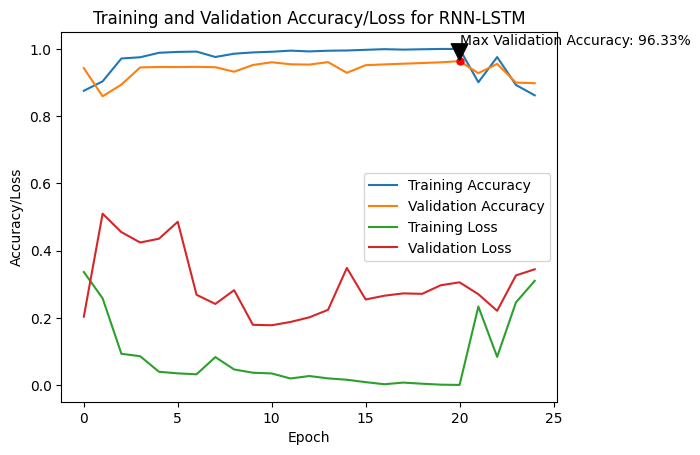

In [28]:
plot_model_loss_accuracy(history_rnn_lstm, "RNN-LSTM")

In [26]:
#save model
model_CNN_LSTM.save('model_CNN_LSTM.h5')
model_bidirectional_LSTM.save('model_bidirectional_LSTM.h5')

In [17]:
# show confusion matrix with original labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model_bidirectional_LSTM.predict(test_df_data)


1761/1761 [==============================] - 44s 25ms/step


['FTP' 'FTP' 'FTP' ... 'SYN Flood' 'SYN Flood' 'SYN Flood']
[[4.23474972e-07 6.56152395e-07 1.31381045e-10 ... 9.99998927e-01
  1.74619359e-08 1.11875724e-10]
 [8.61764704e-07 2.54186170e-06 6.45748011e-10 ... 9.99996543e-01
  5.54689272e-08 3.72186643e-10]
 [1.76765957e-06 5.33530465e-06 1.64171321e-09 ... 9.99992609e-01
  9.52259924e-08 7.24309224e-10]
 ...
 [1.21299074e-14 5.23425227e-11 2.27604042e-15 ... 4.47301243e-15
  1.00000000e+00 1.01709889e-19]
 [1.30637265e-14 5.41270744e-11 2.43071965e-15 ... 4.73664170e-15
  1.00000000e+00 1.08962382e-19]
 [1.38872610e-14 5.63502821e-11 2.58687589e-15 ... 5.03027541e-15
  1.00000000e+00 1.16797928e-19]]
Confusion Matrix:
[[    0     0     0     0   722     0     0]
 [    0   269     0     0    12  1218     0]
 [    0   982     0    12     0  1605     0]
 [    0     0     0     0     0  2099     0]
 [    0     3     0     0  3096     0     0]
 [    0     0     0     0     0 44810     0]
 [    0   149     0     0  1234   116     0]]


c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

          FTP       0.00      0.00      0.00       722
    FTP + SSH       0.19      0.18      0.19      1499
    Keylogger       0.00      0.00      0.00      2599
Reverse Shell       0.00      0.00      0.00      2099
          SSH       0.61      1.00      0.76      3099
    SYN Flood       0.90      1.00      0.95     44810
          nan       0.00      0.00      0.00      1499

     accuracy                           0.86     56327
    macro avg       0.24      0.31      0.27     56327
 weighted avg       0.75      0.86      0.80     56327



c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


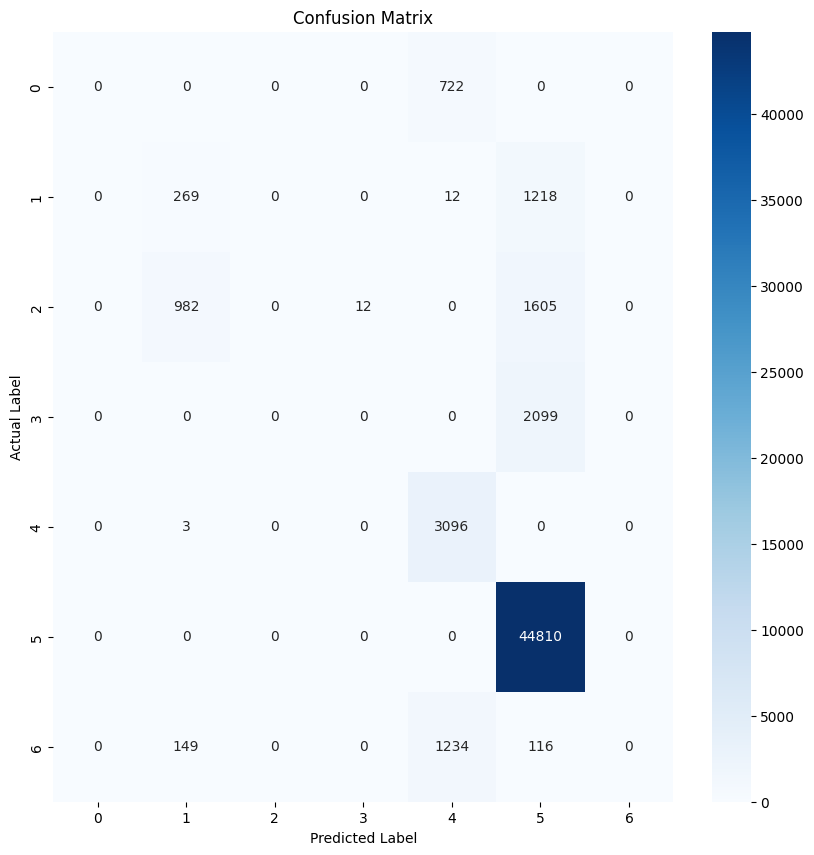

In [22]:
y_pred_labels = np.argmax(y_pred, axis=1)


reverse_label_map = {label_encoder_test.transform([label])[0]: label for label in label_encoder_test.classes_}

# Map the encoded labels back to original labels using the reverse mapping
y_true = np.vectorize(reverse_label_map.get)(test_target)
y_pred_labels = np.vectorize(reverse_label_map.get)(y_pred_labels)
print(y_true)
print(y_pred)

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
print('Confusion Matrix:')
print(cm)

# Print classification report
cr = classification_report(y_true, y_pred_labels)
print('Classification Report:')
print(cr)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



# VAE for dectection of anomalies

In [41]:
import tensorflow as tf
from tensorflow import keras

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

latent_dim = 32
input_shape = (128, 7) # sequence length is 128

# Define encoder
encoder_inputs = keras.Input(shape=input_shape)
x = keras.layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = keras.layers.LSTM(32)(x)
mean = keras.layers.Dense(latent_dim, name='mean')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name='encoder')

# Define decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.RepeatVector(input_shape[0])(latent_inputs)
x = keras.layers.LSTM(32, return_sequences=True)(x)
decoder_outputs = keras.layers.LSTM(64, return_sequences=True)(x)
decoder_outputs = keras.layers.Dense(input_shape[1])(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE as a combination of encoder and decoder
vae_outputs = decoder(z)
vae = keras.Model(encoder_inputs, vae_outputs, name='vae')

# Define loss function for VAE
kl_loss = -0.5 * tf.reduce_mean(log_var - tf.square(mean) - tf.exp(log_var) + 1)
reconstruction_loss = keras.losses.mse(encoder_inputs, vae_outputs)
vae_loss = reconstruction_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')




vae.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 7)]     0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 128, 64)      18432       ['input_7[0][0]']                
                                                                                                  
 lstm_13 (LSTM)                 (None, 32)           12416       ['lstm_12[0][0]']                
                                                                                                  
 mean (Dense)                   (None, 32)           1056        ['lstm_13[0][0]']                
                                                                                                

In [43]:
# fit VAE
vae.fit(train_df_data, epochs=10, batch_size=256, validation_data=(val_df_data, None))


Epoch 1/10
131/131 [==============================] - 6s 46ms/step - loss: 149471552.0000 - val_loss: 17160744.0000
Epoch 2/10
131/131 [==============================] - 6s 42ms/step - loss: 149312784.0000 - val_loss: 17112784.0000
Epoch 3/10
131/131 [==============================] - 5s 40ms/step - loss: 149177376.0000 - val_loss: 17068462.0000
Epoch 4/10
131/131 [==============================] - 5s 41ms/step - loss: 149049024.0000 - val_loss: 17025880.0000
Epoch 5/10
131/131 [==============================] - 5s 40ms/step - loss: 148924320.0000 - val_loss: 16984228.0000
Epoch 6/10
131/131 [==============================] - 5s 41ms/step - loss: 148798528.0000 - val_loss: 16941152.0000
Epoch 7/10
131/131 [==============================] - 5s 41ms/step - loss: 148672704.0000 - val_loss: 16899380.0000
Epoch 8/10
131/131 [==============================] - 5s 42ms/step - loss: 148549552.0000 - val_loss: 16858206.0000
Epoch 9/10
131/131 [==============================] - 6s 42ms/step - los